# Face Landmarks Prediction

## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
from pathlib import Path
from multiprocessing import cpu_count
import sys

In [3]:
# ignite engine
import ignite
from ignite import engine as ie
from ignite.metrics import Loss
from ignite.handlers import EarlyStopping, Timer, ModelCheckpoint
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler

# torch
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

# everything else
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Notebook Configuration

In [4]:
DEBUG = True
SEED = 1
DEVICE = torch.device('cuda:1')
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if DEBUG:
    num_workers = 0
else:
    num_workers = cpu_count()
    os.environ['PYTHONBREAKPOINT'] = '0'

try:
    old_path
except NameError:
    old_path = sys.path
    new_path = [str(Path.cwd()/'loop')] + old_path
    sys.path = new_path

## Local Scripts

In [27]:
from dataset import FaceLandmarks, dataset_info
from layers import fc, conv
from loop.torch_helpers.modules import AdaptiveConcatPool2d, Flatten, classname
from metrics import rmse_loss
from transform import MatrixAugmentation, AdjustGamma, CropResizeFace, ToXY
from utils import split

# Data Preview

In [6]:
path, num_landmarks = dataset_info('umdfaces', 'meta.json')
path

'/home/ck/data/umdfaces/cropped'

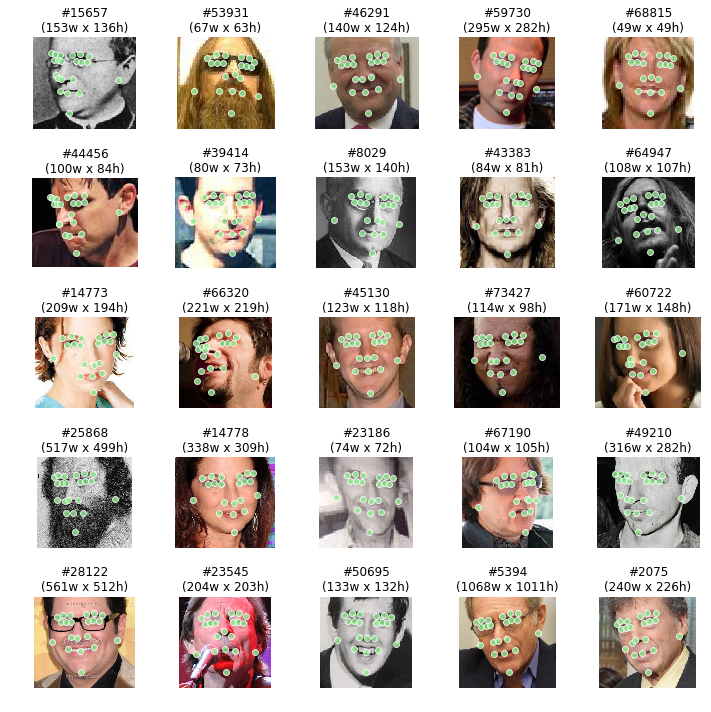

In [7]:
FaceLandmarks.read_folder(path, num_landmarks).show_random_grid(5)

In [8]:
def get_transforms(img_size=128, pad=0):
    train_tfm = [
        MatrixAugmentation([
            {'name': 'rotation', 'angle': 10},
            {'name': 'mirror'},
            {'name': 'perspective', 'percentage': (0.075, 0.012)}]),
        CropResizeFace(size=img_size, pad=pad),
        AdjustGamma(min_gamma=0.8)]
    valid_tfm = [CropResizeFace(size=img_size, pad=pad)]
    return train_tfm, valid_tfm

In [9]:
sz, pad = 128, 0.15

In [10]:
trn_ds, val_ds = FaceLandmarks.create_datasets(
    path, num_landmarks, 
    transforms=get_transforms(img_size=sz, pad=pad),
    to_tensors=ToXY())

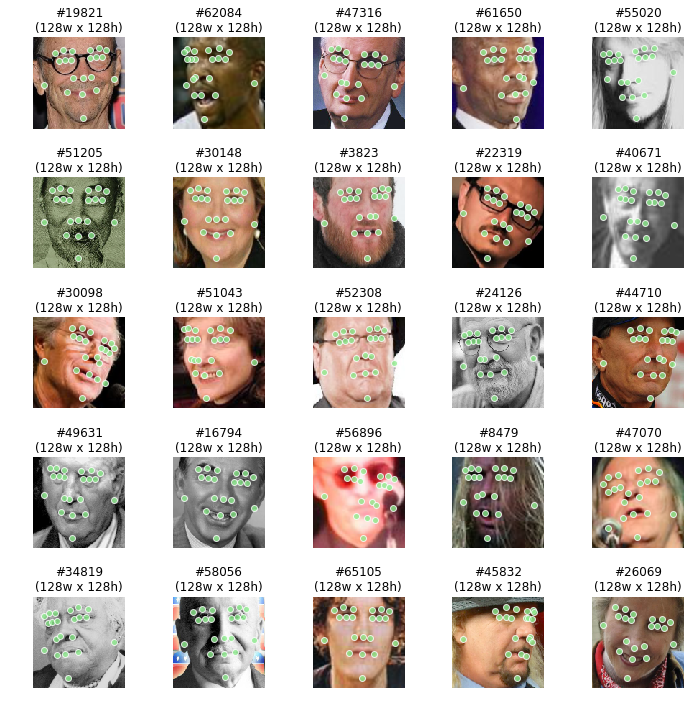

In [11]:
trn_ds.show_random_grid(5, transformed=True)

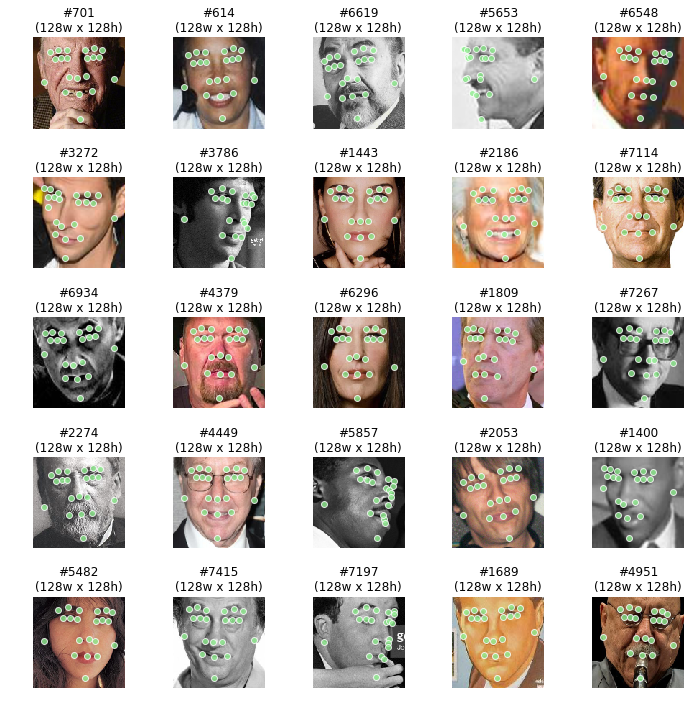

In [12]:
val_ds.show_random_grid(5, transformed=True)

# Models

## Dataset Stats

In [13]:
def to_np(t):
    return t.cpu().detach().numpy()

In [14]:
def compute_featurewise_mean_std(dataset, batch_size=512):
    n = 1
    mean, var = None, None
    for i in range(len(dataset)):
        x, _ = dataset[i]
        x = x.clone().detach()
        if isinstance(x, torch.ByteTensor):
            x = x.float().div(255)
        if var is None and mean is None:
            mean, var = x, torch.ones_like(x)
        else:
            var.mul_(n - 2).div_(n - 1)
            var.add_(x.sub(mean).pow(2).div(n))
            mean.mul_(n - 1).add_(x).div_(n)
        n += 1
    var.sqrt_().add_(1e-7)
    return mean, var

In [15]:
def compute_channelwise_stats(folder, num_landmarks, img_size, pad, batch_size=512):
    ds = FaceLandmarks.read_folder(path, num_landmarks)
    ds.transforms = [CropResizeFace(size=img_size, pad=pad)]
    ds.to_tensors = ToXY()
    mean_img, std_img = compute_featurewise_mean_std(ds, batch_size)
    if mean_img.size(0) == 3:
        mean = mean_img.mean(dim=1).mean(dim=1)
        std = std_img.mean(dim=1).mean(dim=1)
    else:
        mean = mean_img.mean()
        std = std_img.mean()
    return mean, std

In [16]:
# stats = compute_channelwise_stats(path, num_landmarks, img_size=sz, pad=pad)
# torch.save(stats, 'stats.pth')

In [17]:
stats = torch.load('stats.pth')
stats

(tensor([0.5379, 0.4338, 0.3892]), tensor([0.2513, 0.2351, 0.2360]))

In [18]:
class LandmarksRegressor(nn.Module):
    def __init__(self, layers, top=None):
        super().__init__()
        if top is not None:
            layers.append(top)
        self.model = nn.ModuleList(layers)
        self.model.apply(self.init)
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x
        
    def init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            nn.init.zeros_(m.bias)
        elif classname(m).startswith('BatchNorm'):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 1e-3)

In [19]:
def create_data_loaders(train_data, valid_data, bs=512, num_workers=0):
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_data, batch_size=bs, shuffle=False, num_workers=num_workers)
    return train_loader, valid_loader

## Simple VGG-Face Model

In [20]:
def conv_model(ni, no, pool=False, res=True):
    pool = (2, 2) if pool else None
    stride = 1 if pool is not None else 2
    layers  = conv( ni,  16, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += conv( 16,  32, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += conv( 32,  64, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += conv( 64, 128, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += conv(128, 256, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += [AdaptiveConcatPool2d(1), Flatten()]
    layers += fc(512, 500, dropout=0.50, activ='relu')
    layers += fc(500, 500, dropout=0.50, activ='relu')
    layers += fc(500, 500, dropout=0.25, activ='relu')
    layers += fc(500, no)
    return layers

In [21]:
def deep_model(ni, no):
    layers  = conv(  ni,   64, 3, stride=1, pad=1, bn=True, activ='leaky_relu')
    layers += conv(  64,   64, 3, stride=1, pad=1, bn=True, activ='leaky_relu')
    layers += conv(  64,  128, 3, stride=2, pad=1, bn=True, activ='leaky_relu')
    
    layers += conv( 128,  128, 3, stride=1, pad=1, bn=True, activ='leaky_relu')
    layers += conv( 128,  128, 3, stride=1, pad=1, bn=True, activ='leaky_relu')
    layers += conv( 128,  256, 3, stride=2, pad=1, bn=True, activ='leaky_relu')
    
    layers += conv( 256,  256, 3, stride=1, pad=1, bn=True, activ='leaky_relu')
    layers += conv( 256,  256, 3, stride=1, pad=1, bn=True, activ='leaky_relu')
    layers += conv( 256,  512, 3, stride=2, pad=1, bn=True, activ='leaky_relu')
    
    layers += conv( 512,  512, 3, stride=1, pad=1, bn=True, activ='leaky_relu')
    layers += conv( 512,  512, 3, stride=1, pad=1, bn=True, activ='leaky_relu')
    layers += conv( 512, 1024, 3, stride=2, pad=1, bn=True, activ='leaky_relu')
    
    layers += conv(1024, 2048, 1, stride=1, pad=0, bn=True, activ='leaky_relu')
    
    layers += [AdaptiveConcatPool2d(1), Flatten()]
    
    layers += fc(4096, no)
    
    return layers

In [22]:
reg = LandmarksRegressor(deep_model(3, num_landmarks), top=nn.Tanh())

In [23]:
from fastprogress import master_bar, progress_bar

In [24]:
# configuring optimizer and training loop
opt = optim.Adam(reg.parameters())
loss = rmse_loss
trainer = ie.create_supervised_trainer(reg, opt, loss, device=DEVICE)
evaluator = ie.create_supervised_evaluator(reg, device=DEVICE, metrics={'rmse': Loss(loss)})

def score_function(engine):
    val_loss = engine.state.metrics['rmse']
    return -val_loss

bs = 70
epochs = 500

# preparing data loaders and training loop
trn_dl, val_dl = create_data_loaders(trn_ds, val_ds, bs=bs, num_workers=num_workers)
sched = CosineAnnealingScheduler(opt, 'lr', 1e-1, 1e-4, cycle_size=len(trn_dl), cycle_mult=2)
early_stopping = EarlyStopping(patience=250, score_function=score_function, trainer=trainer)
checkpoint = ModelCheckpoint('/tmp/models/', 'zero',
                             score_name='rmse_val_loss',
                             require_empty=False, 
                             score_function=score_function,
                             create_dir=True)

# variables
iter_log_interval = len(trn_dl) // 10
epoch_log_interval = 5
lrs = []

# binding events
trainer.add_event_handler(ie.Events.ITERATION_COMPLETED, sched)
evaluator.add_event_handler(ie.Events.COMPLETED, checkpoint, {'model': reg})
evaluator.add_event_handler(ie.Events.COMPLETED, early_stopping)

@trainer.on(ie.Events.ITERATION_COMPLETED)
def save_lr(engine):
    lrs.append(opt.param_groups[0]['lr'])

@trainer.on(ie.Events.ITERATION_COMPLETED)
def log_iteration_progress(engine):
    iteration = engine.state.iteration
    if iteration % iter_log_interval == 0:
        print(f'Iteration {iteration:3d} | Batch loss: {engine.state.output:.4f}')
    
@trainer.on(ie.Events.EPOCH_COMPLETED)
def log_training_results(engine):
    epoch = engine.state.epoch
    evaluator.run(trn_dl)
    metrics = evaluator.state.metrics
    avg_loss = metrics['rmse']
    if epoch % epoch_log_interval == 0:
        print(f'Train - Epoch: {epoch} - Avg loss {avg_loss:.4f}')
    
@trainer.on(ie.Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    epoch = engine.state.epoch
    evaluator.run(val_dl)
    metrics = evaluator.state.metrics
    avg_loss = metrics['rmse']
    if epoch % epoch_log_interval == 0:
        print(f'Valid - Epoch: {epoch} - Avg loss: {avg_loss:.4f}')

In [25]:
trainer.run(trn_dl, max_epochs=epochs)

Iteration  99 | Batch loss: 0.3211
Iteration 198 | Batch loss: 0.3133
Iteration 297 | Batch loss: 0.3093
Iteration 396 | Batch loss: 0.3092
Iteration 495 | Batch loss: 0.3085
Iteration 594 | Batch loss: 0.3132
Iteration 693 | Batch loss: 0.3141
Iteration 792 | Batch loss: 0.3076
Iteration 891 | Batch loss: 0.3049
Iteration 990 | Batch loss: 0.3082


/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LandmarksRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Iteration 1089 | Batch loss: 0.3109
Iteration 1188 | Batch loss: 0.3199
Iteration 1287 | Batch loss: 0.3197
Iteration 1386 | Batch loss: 0.3069
Iteration 1485 | Batch loss: 0.3080
Iteration 1584 | Batch loss: 0.3041
Iteration 1683 | Batch loss: 0.3049
Iteration 1782 | Batch loss: 0.3067
Iteration 1881 | Batch loss: 0.3059
Iteration 1980 | Batch loss: 0.3167
Iteration 2079 | Batch loss: 0.3095
Iteration 2178 | Batch loss: 0.3089
Iteration 2277 | Batch loss: 0.3087
Iteration 2376 | Batch loss: 0.3104
Iteration 2475 | Batch loss: 0.3061
Iteration 2574 | Batch loss: 0.3091
Iteration 2673 | Batch loss: 0.3078
Iteration 2772 | Batch loss: 0.3123
Iteration 2871 | Batch loss: 0.3018
Iteration 2970 | Batch loss: 0.3072
Iteration 3069 | Batch loss: 0.3143
Iteration 3168 | Batch loss: 0.3137
Iteration 3267 | Batch loss: 0.3112
Iteration 3366 | Batch loss: 0.3142
Iteration 3465 | Batch loss: 0.3087
Iteration 3564 | Batch loss: 0.3148
Iteration 3663 | Batch loss: 0.3123
Iteration 3762 | Batch loss:

KeyboardInterrupt: 

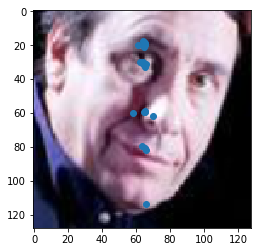

In [28]:
test_img, test_pts = val_ds[0]
reg.eval()
pred = reg(test_img[None].to(DEVICE))
np_img, np_pts = val_ds.to_tensors.inverse(test_img, pred)
plt.imshow(np_img)
plt.scatter(*split(np_pts, num_landmarks))